In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from torch.nn.functional import relu
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import math

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") #using gpu
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [3]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

Minimum value: 0.0117647061124444
Maximum value: 1.0


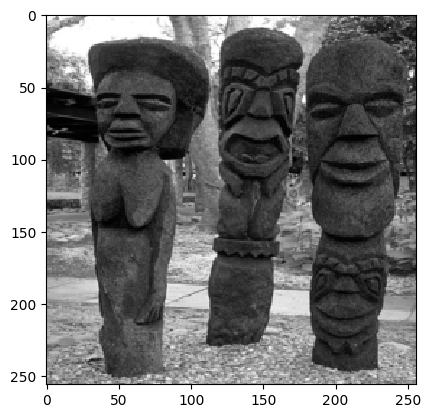

In [4]:
image = Image.open("blurImages/test001.png")
testOutput = preprocess(image).unsqueeze(0)

min_value = np.min(testOutput.squeeze(0).cpu().numpy())
max_value = np.max(testOutput.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
plt.imshow(testOutput.squeeze().numpy(),cmap='gray',interpolation='none')

In [5]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(2,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

In [6]:
kernel_size = 9
if kernel_size%2 == 0: #kernel size should be odd
    kernel_size = kernel_size-1

In [7]:
def create_gaussian_kernel(kernel_size=9, sigma=1.5):
    
    x = torch.arange(kernel_size) - (kernel_size - 1) / 2
    y = x.view(kernel_size, 1)
    x2y2 = x**2 + y**2
    
    gaussian_kernel = torch.exp(-x2y2 / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / (2 * np.pi * sigma**2)
    
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    return gaussian_kernel

In [8]:
#noise level map
def genNoiseMap(image, sigmaNorm):
    noiselvlMap = torch.full_like(image, sigmaNorm)
    return noiselvlMap
def combineImgandMap(imageNoised, noiselvlMap): #input image needs to be noised
    combinedInput = torch.cat((imageNoised, noiselvlMap), dim=1)
    return combinedInput
def addNoiseMap(imageNoised, sigmaNorm): #image needs to be noised, sigma should be normalized?
    noiselvlMap = genNoiseMap(imageNoised, sigmaNorm)
    return combineImgandMap(imageNoised, noiselvlMap)

In [9]:
class BlurModel(nn.Module):
    def __init__(self):
        super(BlurModel, self).__init__()
        
        self.k= create_gaussian_kernel(kernel_size, 1.5)

        self.k = self.k.view(1,1,kernel_size,kernel_size)
        self.k = self.k.to(device)
    # def forward(self, x, sigma=0):
    #     # A y

    #     #need new padding size with larger kernel
    #     padding_size = kernel_size//2
        
    #     x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
    #     #applying blur and noise
    #     y = F.conv2d(x_padded, self.k) + sigma * torch.randn_like(x)
    #     return y

    def forward(self, x):
        # A y

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
        #applying blur without noise
        y = F.conv2d(x_padded, self.k)
        return y
    
    def tran(self, y):
        # A^T y
#         x = NotImplemented # hint: transpose the blur kernel
        self.k = torch.transpose(self.k, 0, 1)

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        y_padded = F.pad(y, (padding_size, padding_size, padding_size, padding_size), mode='circular')
        #kTranposed = self.k.t()
        x = F.conv2d(y_padded, self.k, padding=0) #self.k is symmetric
        return x
    
    def grad(self, x, y):
        # gradient of 0.5 || Ax - y ||^2 --> grad = A^T(Ax - y)
        g = self.tran( self.forward(x) - y )
        return g

    def calcLoss(self, x, y):
        diff = self.forward(x) - y
        diffSquared = diff ** 2
        return 0.5*torch.sum(diffSquared)


In [10]:
def psnrCalc(mse, max):
    return 10*np.log10((max**2)/mse)


In [11]:
def run_PnP_ISTA(
             x0,
             A, 
             denoiser,
             meas, 
             stepsize,
             gt_img, 
             max_iter,
             sigmaNoiseMap,
             meas_sigma,
            ):
    # ############################
    # A basic implementation of PnP ISTA
    # ############################

    #initializing and adding noise
    x = x0 + meas_sigma * torch.randn_like(x0)
    with torch.no_grad():
        for i in tqdm(range(max_iter)):
            # Look at PnP ISTA update steps
            
            z = x - stepsize*A.grad(x, meas) #prev x - stepsize*grad(prev x)

            #adding noise map to z:
            z = addNoiseMap(z, sigmaNoiseMap)

            #plug into denoiser
            x = denoiser(z)
        
            #Feel free to add psnr/ssim tracking
            #track loss of (y-AX)^2
            #check if fista is running properly: set x=z, initailize image to zeros, simga=0 and you'll converge
            if i % 10 == 0:
                gt_img_np = gt_img.cpu().detach().numpy() if gt_img.is_cuda else gt_img.numpy()
                x_np = x.cpu().detach().numpy() if x.is_cuda else x.detach().numpy()
                meas_np = meas.cpu().detach().numpy() if meas.is_cuda else x.detach().numpy()
                #psnr of output
                mseTerm = mse(gt_img_np,x_np)
                curPsnr = psnrCalc(mseTerm, 1)
                curLoss = A.calcLoss(x, meas)
        
                #psnr of measurement
                mseTermMeas = mse(gt_img_np,meas_np)
                curPsnrMeas = psnrCalc(mseTermMeas, 1)

                psnrList.append(curPsnr)
                lossList.append(curLoss) #x is clean image, y is measurement
                print(f"At iter {i}, loss is: {curLoss}, PSNR of output is: {curPsnr}, PSNR of input is: {curPsnrMeas}");
    return x

In [12]:
findBestStepSize = False

In [13]:
max_iter = 200
stepsize = [2, 1, 0.9, 0.8, 0.5, 0.3, 0.1, 0.05, 0.01] # play with this
meas_sigma = 15 / 255 # play with this (note that it does not need to be same as the sigma you used for training)
bestPsnr = float('-inf')
bestStepSize = 0
#sigma for noise map
sigmaSampled = torch.randint(1,50,(1,1)).item() #each image have diff sigma
sigmaNoiseMap = sigmaSampled/255

A = BlurModel().to(device) # forward model

clean_img = preprocess(image).unsqueeze(0)
clean_img = clean_img.to(device)
blurry_img = A(clean_img)

network = UNetDenoise()
network.load_state_dict(torch.load('denoiserModelBestWeightswNoiseMap.pth')) # Your NN you trained 
#denoiserFinalWeights.pth denoiserModelBestWeights.pth denoiserFinalWeightsEarlyStopped.pth denoiserModelBestWeightsEarlyStopped.pth denoiserFinalWeightswNoiseMap.pth 
network.eval()

#x0 = torch.zeros_like(blurry_img)
x0 = blurry_img
network.to(device)
blurry_img = blurry_img.to(device)

x0 = x0.to(device)
# if findBestStepSize:
#     for aStepsize in stepsize:
#         lossList = list()
#         psnrList = list()
#         print(f'step size of: {aStepsize}')
#         recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
#                              A = A, 
#                              denoiser = network,
#                              meas = blurry_img, 
#                              stepsize = aStepsize,
#                              gt_img = clean_img, 
#                              max_iter = max_iter
#                         )
#         print(f'final psnr with stepsize {aStepsize}: {psnrList[-1]}')
    
#         if psnrList[-1] > bestPsnr:
#             bestPsnr = psnrList[-1]
#             bestStepSize = aStepsize
    
#         fig, ax = plt.subplots(1,4)
#         plt.title(f'At StepSize: {aStepsize} clean, pre reconstruction, measurment, and estimated images')
#         ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')


  1%|▏         | 7/500 [00:00<00:07, 67.99it/s]

At iter 0, loss is: 6.8276166915893555, PSNR of output is: 24.701335820004523, PSNR of input is: 24.799891158716747


  3%|▎         | 14/500 [00:00<00:11, 41.33it/s]

At iter 10, loss is: 5.206457614898682, PSNR of output is: 25.036458653811206, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:12, 37.91it/s]

At iter 20, loss is: 5.229925155639648, PSNR of output is: 25.026747323458668, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:00<00:11, 41.88it/s]

At iter 30, loss is: 5.240886211395264, PSNR of output is: 25.020070682824958, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:09, 45.01it/s]

At iter 40, loss is: 5.245335578918457, PSNR of output is: 25.01663974602364, PSNR of input is: 24.799891158716747
At iter 50, loss is: 5.246405601501465, PSNR of output is: 25.015341557698537, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:09, 45.67it/s]

At iter 60, loss is: 5.246042251586914, PSNR of output is: 25.015200431611344, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:09, 46.30it/s]

At iter 70, loss is: 5.245190620422363, PSNR of output is: 25.01558714120105, PSNR of input is: 24.799891158716747


 16%|█▌        | 81/500 [00:01<00:08, 46.58it/s]

At iter 80, loss is: 5.244296073913574, PSNR of output is: 25.016120407569, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:08, 46.71it/s]

At iter 90, loss is: 5.243625164031982, PSNR of output is: 25.016562959717007, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:02<00:08, 46.87it/s]

At iter 100, loss is: 5.243243217468262, PSNR of output is: 25.016838491587535, PSNR of input is: 24.799891158716747
At iter 110, loss is: 5.243091583251953, PSNR of output is: 25.01696173837651, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:08, 46.97it/s]

At iter 120, loss is: 5.243076801300049, PSNR of output is: 25.01698787993754, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:02<00:07, 46.90it/s]

At iter 130, loss is: 5.243120193481445, PSNR of output is: 25.016967748895794, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:03<00:07, 46.96it/s]

At iter 140, loss is: 5.2431745529174805, PSNR of output is: 25.016935440518267, PSNR of input is: 24.799891158716747
At iter 150, loss is: 5.243215560913086, PSNR of output is: 25.016907755236822, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:07, 47.10it/s]

At iter 160, loss is: 5.243241310119629, PSNR of output is: 25.016889862226066, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:06, 47.06it/s]

At iter 170, loss is: 5.243251800537109, PSNR of output is: 25.016881477855698, PSNR of input is: 24.799891158716747


 36%|███▌      | 181/500 [00:03<00:06, 47.04it/s]

At iter 180, loss is: 5.243253707885742, PSNR of output is: 25.016879261516316, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:04<00:06, 46.94it/s]

At iter 190, loss is: 5.243250846862793, PSNR of output is: 25.016880465400106, PSNR of input is: 24.799891158716747
At iter 200, loss is: 5.243247032165527, PSNR of output is: 25.01688250999187, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:04<00:05, 47.02it/s]

At iter 210, loss is: 5.243244171142578, PSNR of output is: 25.016884639547854, PSNR of input is: 24.799891158716747
At iter 220, loss is: 5.243242263793945, PSNR of output is: 25.016886123786442, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:04<00:05, 47.08it/s]

At iter 230, loss is: 5.2432403564453125, PSNR of output is: 25.016887030244387, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:05<00:05, 47.25it/s]

At iter 240, loss is: 5.243240833282471, PSNR of output is: 25.016887196461603, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:05<00:05, 47.10it/s]

At iter 250, loss is: 5.243240833282471, PSNR of output is: 25.016887112820065, PSNR of input is: 24.799891158716747
At iter 260, loss is: 5.2432403564453125, PSNR of output is: 25.01688712165111, PSNR of input is: 24.799891158716747


 54%|█████▍    | 271/500 [00:05<00:04, 46.92it/s]

At iter 270, loss is: 5.243241310119629, PSNR of output is: 25.016886982880738, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:06<00:04, 47.07it/s]

At iter 280, loss is: 5.243241310119629, PSNR of output is: 25.016886879295384, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:06<00:04, 46.98it/s]

At iter 290, loss is: 5.243240833282471, PSNR of output is: 25.016886971683128, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:06<00:04, 46.84it/s]

At iter 300, loss is: 5.243241310119629, PSNR of output is: 25.016886777910734, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:06<00:03, 46.91it/s]

At iter 310, loss is: 5.243241310119629, PSNR of output is: 25.01688680172196, PSNR of input is: 24.799891158716747
At iter 320, loss is: 5.243241310119629, PSNR of output is: 25.01688686715374, PSNR of input is: 24.799891158716747


 66%|██████▌   | 331/500 [00:07<00:03, 47.00it/s]

At iter 330, loss is: 5.243241310119629, PSNR of output is: 25.016886895705, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:07<00:03, 46.85it/s]

At iter 340, loss is: 5.243241310119629, PSNR of output is: 25.016886839325274, PSNR of input is: 24.799891158716747
At iter 350, loss is: 5.243241310119629, PSNR of output is: 25.016886910118615, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:07<00:02, 46.89it/s]

At iter 360, loss is: 5.243241310119629, PSNR of output is: 25.016886831425843, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:07<00:02, 46.98it/s]

At iter 370, loss is: 5.243241310119629, PSNR of output is: 25.01688685352283, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:08<00:02, 46.85it/s]

At iter 380, loss is: 5.243241310119629, PSNR of output is: 25.016886868837574, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:08<00:02, 46.75it/s]

At iter 390, loss is: 5.243241310119629, PSNR of output is: 25.01688683579884, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:08<00:02, 46.75it/s]

At iter 400, loss is: 5.243240833282471, PSNR of output is: 25.016886838016106, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:08<00:01, 46.82it/s]

At iter 410, loss is: 5.243241310119629, PSNR of output is: 25.01688676606125, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:09<00:01, 46.80it/s]

At iter 420, loss is: 5.243241310119629, PSNR of output is: 25.016886888190555, PSNR of input is: 24.799891158716747


 86%|████████▌ | 431/500 [00:09<00:01, 46.72it/s]

At iter 430, loss is: 5.243241310119629, PSNR of output is: 25.0168868641655, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:09<00:01, 46.80it/s]

At iter 440, loss is: 5.243241310119629, PSNR of output is: 25.01688683715859, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:09<00:01, 46.79it/s]

At iter 450, loss is: 5.243241310119629, PSNR of output is: 25.01688692160371, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:09<00:00, 46.71it/s]

At iter 460, loss is: 5.243241310119629, PSNR of output is: 25.01688688995553, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:10<00:00, 46.72it/s]

At iter 470, loss is: 5.243241310119629, PSNR of output is: 25.016886904421725, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:10<00:00, 46.67it/s]

At iter 480, loss is: 5.243241310119629, PSNR of output is: 25.016886922891235, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:10<00:00, 47.34it/s]

At iter 490, loss is: 5.243240833282471, PSNR of output is: 25.016886982816615, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

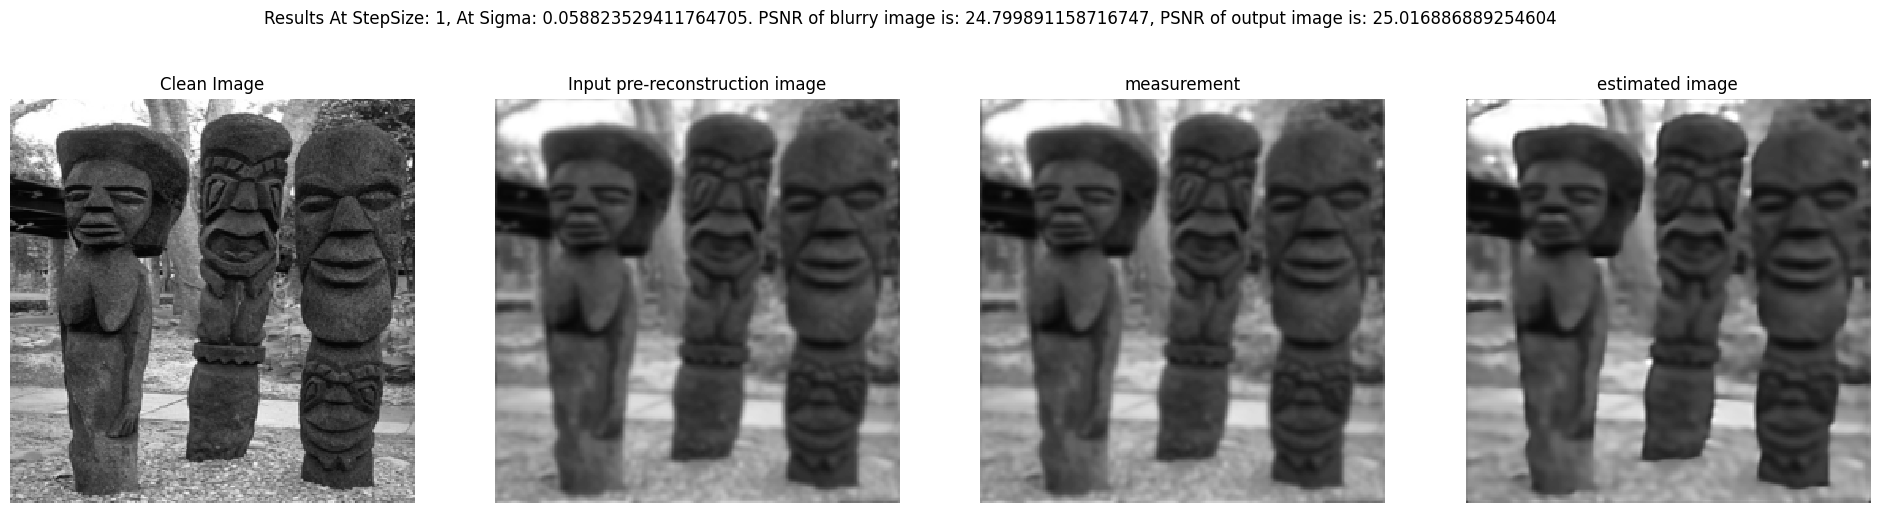

In [14]:
#best step size is found to be 1
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = 1,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap,
                         meas_sigma = meas_sigma
                    )

blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {1}, At Sigma: {meas_sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')

In [15]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

print(f'Final result PSNR of blurred image {finalPsnrMeas}')
print(f'Final result PSNR of reconstructed image {finalPsnrOutput}')

Final result PSNR of blurred image 24.799891158716747
Final result PSNR of reconstructed image 25.016886889254604


In [16]:
import scipy

In [33]:
def objFuncStepSize(stepsize):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=1e-4, gt_img=clean_img, max_iter=200, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=15/255) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [34]:
bestStepsize = scipy.optimize.fminbound(objFuncStepSize,1e-6,2,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 1/200 [00:00<00:25,  7.70it/s]

At iter 0, loss is: 14.908516883850098, PSNR of output is: 23.98986588886501, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 33.15it/s]

At iter 10, loss is: 60.76741027832031, PSNR of output is: 21.890240255654998, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 39.94it/s]

At iter 20, loss is: 121.44097137451172, PSNR of output is: 20.474026092012764, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 43.16it/s]

At iter 30, loss is: 191.14071655273438, PSNR of output is: 19.384811311063796, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.50it/s]

At iter 40, loss is: 265.81378173828125, PSNR of output is: 18.495340497971142, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.28it/s]

At iter 50, loss is: 341.62457275390625, PSNR of output is: 17.75929896677915, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 46.06it/s]

At iter 60, loss is: 416.0008544921875, PSNR of output is: 17.14857301826023, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.56it/s]

At iter 70, loss is: 488.65032958984375, PSNR of output is: 16.62950880839349, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 46.94it/s]

At iter 80, loss is: 560.6638793945312, PSNR of output is: 16.17254131649957, PSNR of input is: 24.799891158716747
At iter 90, loss is: 632.6000366210938, PSNR of output is: 15.76011964414623, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.32it/s]

At iter 100, loss is: 704.922119140625, PSNR of output is: 15.377577831217405, PSNR of input is: 24.799891158716747
At iter 110, loss is: 776.9926147460938, PSNR of output is: 15.015530172821741, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.35it/s]

At iter 120, loss is: 849.457763671875, PSNR of output is: 14.654660497540934, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.37it/s]

At iter 130, loss is: 927.4182739257812, PSNR of output is: 14.262417027225784, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 47.25it/s]

At iter 140, loss is: 1017.0631103515625, PSNR of output is: 13.799540825951667, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.24it/s]

At iter 150, loss is: 1131.859375, PSNR of output is: 13.225136541712029, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.76it/s]

At iter 160, loss is: 1299.7264404296875, PSNR of output is: 12.473002970273866, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.11it/s]

At iter 170, loss is: 1563.037109375, PSNR of output is: 11.477668370823132, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.92it/s]

At iter 180, loss is: 2010.9757080078125, PSNR of output is: 10.200966572408287, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.24it/s]


At iter 190, loss is: 2791.423828125, PSNR of output is: 8.602897747189735, PSNR of input is: 24.799891158716747
 
 Func-count     x          f(x)          Procedure
    1       0.763933     -6.91095        initial


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.627976417541504, PSNR of output is: 24.013703580952075, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.05it/s]

At iter 10, loss is: 60.09206771850586, PSNR of output is: 21.912882565571596, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.38it/s]

At iter 20, loss is: 119.974853515625, PSNR of output is: 20.505046673008653, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.42it/s]

At iter 30, loss is: 188.93865966796875, PSNR of output is: 19.41642328378612, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.10it/s]

At iter 40, loss is: 263.2237854003906, PSNR of output is: 18.524023580581378, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.72it/s]

At iter 50, loss is: 339.31817626953125, PSNR of output is: 17.779288950195276, PSNR of input is: 24.799891158716747
At iter 60, loss is: 414.154296875, PSNR of output is: 17.16091526535203, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.88it/s]

At iter 70, loss is: 487.21917724609375, PSNR of output is: 16.636890665929233, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.98it/s]

At iter 80, loss is: 559.7427978515625, PSNR of output is: 16.176369649343343, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.91it/s]

At iter 90, loss is: 631.6116333007812, PSNR of output is: 15.764760831939604, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.26it/s]

At iter 100, loss is: 702.9948120117188, PSNR of output is: 15.38905949844368, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.70it/s]

At iter 110, loss is: 773.8366088867188, PSNR of output is: 15.038660096944117, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.50it/s]

At iter 120, loss is: 844.1280517578125, PSNR of output is: 14.707841238649666, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.37it/s]

At iter 130, loss is: 915.8714599609375, PSNR of output is: 14.37822583472987, PSNR of input is: 24.799891158716747
At iter 140, loss is: 992.7335205078125, PSNR of output is: 14.013799180337884, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.27it/s]

At iter 150, loss is: 1076.481201171875, PSNR of output is: 13.62418838968781, PSNR of input is: 24.799891158716747
At iter 160, loss is: 1167.6651611328125, PSNR of output is: 13.228133829307055, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.46it/s]

At iter 170, loss is: 1271.1746826171875, PSNR of output is: 12.779816193293335, PSNR of input is: 24.799891158716747


 96%|█████████▌| 191/200 [00:04<00:00, 46.90it/s]

At iter 180, loss is: 1399.798095703125, PSNR of output is: 12.257806558985585, PSNR of input is: 24.799891158716747
At iter 190, loss is: 1582.989501953125, PSNR of output is: 11.592440369903194, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.21it/s]


    2        1.23607     -10.8101        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.115220069885254, PSNR of output is: 24.004278612706635, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 61.20740509033203, PSNR of output is: 21.873748947140964, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.87it/s]

At iter 20, loss is: 121.14840698242188, PSNR of output is: 20.476657710896685, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.36it/s]

At iter 30, loss is: 189.44985961914062, PSNR of output is: 19.403658782562353, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.34it/s]

At iter 40, loss is: 263.03863525390625, PSNR of output is: 18.519919791188716, PSNR of input is: 24.799891158716747
At iter 50, loss is: 337.65887451171875, PSNR of output is: 17.78909948119616, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.98it/s]

At iter 60, loss is: 410.48211669921875, PSNR of output is: 17.18385598736775, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.05it/s]

At iter 70, loss is: 481.8859558105469, PSNR of output is: 16.66714481577678, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.17it/s]

At iter 80, loss is: 553.06591796875, PSNR of output is: 16.21113306165367, PSNR of input is: 24.799891158716747
At iter 90, loss is: 624.802978515625, PSNR of output is: 15.797022683307258, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.42it/s]

At iter 100, loss is: 696.8309936523438, PSNR of output is: 15.415975082877196, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.00it/s]

At iter 110, loss is: 768.146240234375, PSNR of output is: 15.06403116514915, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.86it/s]

At iter 120, loss is: 839.2610473632812, PSNR of output is: 14.727520474510694, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.62it/s]

At iter 130, loss is: 911.2586669921875, PSNR of output is: 14.386226410383872, PSNR of input is: 24.799891158716747
At iter 140, loss is: 986.9085693359375, PSNR of output is: 14.026937189459733, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.16it/s]

At iter 150, loss is: 1064.7952880859375, PSNR of output is: 13.692879661541609, PSNR of input is: 24.799891158716747
At iter 160, loss is: 1145.3974609375, PSNR of output is: 13.370222923442958, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.97it/s]

At iter 170, loss is: 1231.852783203125, PSNR of output is: 13.036903871071761, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.45it/s]

At iter 180, loss is: 1327.1048583984375, PSNR of output is: 12.676108306325665, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.37it/s]


At iter 190, loss is: 1436.47216796875, PSNR of output is: 12.259387548326101, PSNR of input is: 24.799891158716747
    3        1.52786     -11.8149        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.178720474243164, PSNR of output is: 23.986949145861175, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.11it/s]

At iter 10, loss is: 60.981361389160156, PSNR of output is: 21.876059519339783, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.91it/s]

At iter 20, loss is: 121.4627914428711, PSNR of output is: 20.468223371302244, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.76it/s]

At iter 30, loss is: 190.70587158203125, PSNR of output is: 19.386352784332473, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.02it/s]

At iter 40, loss is: 264.849609375, PSNR of output is: 18.501693857342335, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.16it/s]

At iter 50, loss is: 340.088623046875, PSNR of output is: 17.769675660533334, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.25it/s]

At iter 60, loss is: 413.9693603515625, PSNR of output is: 17.161921868595456, PSNR of input is: 24.799891158716747
At iter 70, loss is: 486.1647644042969, PSNR of output is: 16.64555149921855, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.55it/s]

At iter 80, loss is: 558.2410278320312, PSNR of output is: 16.187648588986796, PSNR of input is: 24.799891158716747
At iter 90, loss is: 630.3355712890625, PSNR of output is: 15.77594938575638, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.60it/s]

At iter 100, loss is: 701.8751831054688, PSNR of output is: 15.403515690415812, PSNR of input is: 24.799891158716747
At iter 110, loss is: 773.0968627929688, PSNR of output is: 15.059219149743488, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.62it/s]

At iter 120, loss is: 844.925048828125, PSNR of output is: 14.732219317573668, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.65it/s]

At iter 130, loss is: 917.0855712890625, PSNR of output is: 14.417171481595783, PSNR of input is: 24.799891158716747
At iter 140, loss is: 988.888427734375, PSNR of output is: 14.104441306013797, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.60it/s]

At iter 150, loss is: 1064.029541015625, PSNR of output is: 13.757340814835356, PSNR of input is: 24.799891158716747
At iter 160, loss is: 1149.7333984375, PSNR of output is: 13.347554461865766, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.61it/s]

At iter 170, loss is: 1259.485595703125, PSNR of output is: 12.852448960420624, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.62it/s]

At iter 180, loss is: 1408.7777099609375, PSNR of output is: 12.254861787980362, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.34it/s]


At iter 190, loss is: 1641.8489990234375, PSNR of output is: 11.433049350699921, PSNR of input is: 24.799891158716747
    4        1.65512     -10.4524        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.349465370178223, PSNR of output is: 23.98209223614632, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.83it/s]

At iter 10, loss is: 61.2915153503418, PSNR of output is: 21.878569999094285, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.29it/s]

At iter 20, loss is: 122.48348999023438, PSNR of output is: 20.461533995488153, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.25it/s]

At iter 30, loss is: 193.10621643066406, PSNR of output is: 19.36445559850505, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.97it/s]

At iter 40, loss is: 268.18994140625, PSNR of output is: 18.47353065328241, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.58it/s]

At iter 50, loss is: 343.9781188964844, PSNR of output is: 17.74006882779235, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.71it/s]

At iter 60, loss is: 417.8441162109375, PSNR of output is: 17.135427119864673, PSNR of input is: 24.799891158716747
At iter 70, loss is: 490.0257263183594, PSNR of output is: 16.620128459436614, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.03it/s]

At iter 80, loss is: 561.3268432617188, PSNR of output is: 16.16760652501235, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 45.86it/s]

At iter 90, loss is: 632.8035888671875, PSNR of output is: 15.757251887441557, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.94it/s]

At iter 100, loss is: 704.4501953125, PSNR of output is: 15.379288812852867, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.46it/s]

At iter 110, loss is: 776.276611328125, PSNR of output is: 15.025389521579358, PSNR of input is: 24.799891158716747
At iter 120, loss is: 848.6119995117188, PSNR of output is: 14.686277568428975, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.95it/s]

At iter 130, loss is: 923.6856079101562, PSNR of output is: 14.34043816138079, PSNR of input is: 24.799891158716747
At iter 140, loss is: 1004.7364501953125, PSNR of output is: 13.954545351110061, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.16it/s]

At iter 150, loss is: 1094.07275390625, PSNR of output is: 13.534607854783928, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.90it/s]

At iter 160, loss is: 1194.39794921875, PSNR of output is: 13.083578208780388, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.60it/s]

At iter 170, loss is: 1320.931884765625, PSNR of output is: 12.545846535094235, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.84it/s]

At iter 180, loss is: 1497.449462890625, PSNR of output is: 11.872919841645919, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.51it/s]


At iter 190, loss is: 1758.92626953125, PSNR of output is: 11.02378460146003, PSNR of input is: 24.799891158716747
    5        1.43295     -10.0145        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.452531814575195, PSNR of output is: 23.960657215302007, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 47.24it/s]

At iter 10, loss is: 61.36425018310547, PSNR of output is: 21.871824422369986, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.08it/s]

At iter 20, loss is: 121.85916137695312, PSNR of output is: 20.464696263619622, PSNR of input is: 24.799891158716747
At iter 30, loss is: 191.09423828125, PSNR of output is: 19.38467073736914, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.70it/s]

At iter 40, loss is: 265.41375732421875, PSNR of output is: 18.500603240376797, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.87it/s]

At iter 50, loss is: 341.34423828125, PSNR of output is: 17.764276000068836, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.76it/s]

At iter 60, loss is: 414.95501708984375, PSNR of output is: 17.15836313223709, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.77it/s]

At iter 70, loss is: 486.928955078125, PSNR of output is: 16.640845883034846, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.18it/s]

At iter 80, loss is: 558.9805908203125, PSNR of output is: 16.178648632698824, PSNR of input is: 24.799891158716747
At iter 90, loss is: 631.28076171875, PSNR of output is: 15.757355087010346, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.19it/s]

At iter 100, loss is: 703.769287109375, PSNR of output is: 15.36213620072255, PSNR of input is: 24.799891158716747
At iter 110, loss is: 778.2893676757812, PSNR of output is: 14.965266353185614, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.30it/s]

At iter 120, loss is: 857.6770629882812, PSNR of output is: 14.543834475859807, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.20it/s]

At iter 130, loss is: 940.5360717773438, PSNR of output is: 14.135036036656729, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.20it/s]

At iter 140, loss is: 1024.52783203125, PSNR of output is: 13.761719131739902, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.13it/s]

At iter 150, loss is: 1109.649658203125, PSNR of output is: 13.407826230673066, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.15it/s]

At iter 160, loss is: 1198.4989013671875, PSNR of output is: 13.056486172444522, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.23it/s]

At iter 170, loss is: 1293.7022705078125, PSNR of output is: 12.692936092858806, PSNR of input is: 24.799891158716747
At iter 180, loss is: 1398.2822265625, PSNR of output is: 12.298137104525912, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.03it/s]


At iter 190, loss is: 1517.809326171875, PSNR of output is: 11.851465907211356, PSNR of input is: 24.799891158716747
    6        1.57647     -11.4004        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.957275390625, PSNR of output is: 23.97092095178358, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.64it/s]

At iter 10, loss is: 60.58193588256836, PSNR of output is: 21.889470061490947, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.16it/s]

At iter 20, loss is: 121.10126495361328, PSNR of output is: 20.473884314914926, PSNR of input is: 24.799891158716747
At iter 30, loss is: 190.3287353515625, PSNR of output is: 19.388830123066, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.09it/s]

At iter 40, loss is: 264.56890869140625, PSNR of output is: 18.500802543094363, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.05it/s]

At iter 50, loss is: 339.9644775390625, PSNR of output is: 17.765687863262645, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.02it/s]

At iter 60, loss is: 413.76055908203125, PSNR of output is: 17.15704100128252, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.05it/s]

At iter 70, loss is: 486.19342041015625, PSNR of output is: 16.63734282399417, PSNR of input is: 24.799891158716747
At iter 80, loss is: 557.9730834960938, PSNR of output is: 16.179960105974192, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.09it/s]

At iter 90, loss is: 629.59326171875, PSNR of output is: 15.769384279880489, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.13it/s]

At iter 100, loss is: 701.8478393554688, PSNR of output is: 15.391671075070196, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.08it/s]

At iter 110, loss is: 774.1239624023438, PSNR of output is: 15.040612077782608, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.07it/s]

At iter 120, loss is: 845.7978515625, PSNR of output is: 14.713324453320656, PSNR of input is: 24.799891158716747
At iter 130, loss is: 916.3734130859375, PSNR of output is: 14.404156188590104, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.09it/s]

At iter 140, loss is: 987.1507568359375, PSNR of output is: 14.091140837510183, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1061.563232421875, PSNR of output is: 13.742152478455518, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.05it/s]

At iter 160, loss is: 1142.041259765625, PSNR of output is: 13.392054860403938, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.10it/s]

At iter 170, loss is: 1228.0576171875, PSNR of output is: 13.050510895681949, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.06it/s]

At iter 180, loss is: 1320.71142578125, PSNR of output is: 12.702368966004505, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.98it/s]


At iter 190, loss is: 1423.2841796875, PSNR of output is: 12.327749658986246, PSNR of input is: 24.799891158716747
    7        1.49161     -11.9508        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.023221015930176, PSNR of output is: 23.988054119554644, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.83it/s]

At iter 10, loss is: 60.89186096191406, PSNR of output is: 21.875091815149908, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.04it/s]

At iter 20, loss is: 120.52919006347656, PSNR of output is: 20.48326144888934, PSNR of input is: 24.799891158716747
At iter 30, loss is: 189.06907653808594, PSNR of output is: 19.406703698905957, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.01it/s]

At iter 40, loss is: 262.8780212402344, PSNR of output is: 18.52162059072846, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.00it/s]

At iter 50, loss is: 337.9425964355469, PSNR of output is: 17.787891739471064, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.07it/s]

At iter 60, loss is: 411.710693359375, PSNR of output is: 17.177286356853482, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.09it/s]

At iter 70, loss is: 483.9976501464844, PSNR of output is: 16.655081256259276, PSNR of input is: 24.799891158716747
At iter 80, loss is: 556.1285400390625, PSNR of output is: 16.18835232330182, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.05it/s]

At iter 90, loss is: 629.1607666015625, PSNR of output is: 15.753675365581003, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.10it/s]

At iter 100, loss is: 704.0072021484375, PSNR of output is: 15.328345912700126, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.06it/s]

At iter 110, loss is: 785.2011108398438, PSNR of output is: 14.86333944534037, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.08it/s]

At iter 120, loss is: 882.2151489257812, PSNR of output is: 14.32444529044606, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1007.909912109375, PSNR of output is: 13.672504204489178, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.05it/s]

At iter 140, loss is: 1196.998291015625, PSNR of output is: 12.791918809552733, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.03it/s]

At iter 150, loss is: 1504.499755859375, PSNR of output is: 11.613590962236158, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.01it/s]

At iter 160, loss is: 2044.4752197265625, PSNR of output is: 10.088228519089315, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.04it/s]

At iter 170, loss is: 2993.23486328125, PSNR of output is: 8.252478357700834, PSNR of input is: 24.799891158716747
At iter 180, loss is: 4739.1220703125, PSNR of output is: 6.152952968525608, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.95it/s]


At iter 190, loss is: 7811.306640625, PSNR of output is: 3.9163640426058905, PSNR of input is: 24.799891158716747
    8        1.47648     -1.79903        parabolic


  6%|▌         | 11/200 [00:00<00:04, 47.03it/s]

At iter 0, loss is: 15.023696899414062, PSNR of output is: 23.976286174407413, PSNR of input is: 24.799891158716747
At iter 10, loss is: 60.75925064086914, PSNR of output is: 21.891842249082224, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.09it/s]

At iter 20, loss is: 120.78271484375, PSNR of output is: 20.490076082993568, PSNR of input is: 24.799891158716747
At iter 30, loss is: 190.17840576171875, PSNR of output is: 19.402609894791823, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.96it/s]

At iter 40, loss is: 265.0623779296875, PSNR of output is: 18.508274293706958, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.04it/s]

At iter 50, loss is: 341.08538818359375, PSNR of output is: 17.768056875995033, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.02it/s]

At iter 60, loss is: 415.056884765625, PSNR of output is: 17.155559884225433, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.01it/s]

At iter 70, loss is: 487.0736083984375, PSNR of output is: 16.635041092222703, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.06it/s]

At iter 80, loss is: 559.0742797851562, PSNR of output is: 16.171628762520122, PSNR of input is: 24.799891158716747
At iter 90, loss is: 632.2762451171875, PSNR of output is: 15.742612846586612, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.03it/s]

At iter 100, loss is: 707.89501953125, PSNR of output is: 15.328556582460372, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.01it/s]

At iter 110, loss is: 786.4624633789062, PSNR of output is: 14.911075152203672, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.87it/s]

At iter 120, loss is: 869.2144775390625, PSNR of output is: 14.483569108605325, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.97it/s]

At iter 130, loss is: 955.1500244140625, PSNR of output is: 14.066788558856507, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.97it/s]

At iter 140, loss is: 1042.794677734375, PSNR of output is: 13.67811900158042, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.10it/s]

At iter 150, loss is: 1133.27490234375, PSNR of output is: 13.30046123277629, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.06it/s]

At iter 160, loss is: 1230.84765625, PSNR of output is: 12.910346897176323, PSNR of input is: 24.799891158716747
At iter 170, loss is: 1341.7481689453125, PSNR of output is: 12.475543969030225, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.03it/s]

At iter 180, loss is: 1476.486083984375, PSNR of output is: 11.957990434960431, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.96it/s]


At iter 190, loss is: 1658.83447265625, PSNR of output is: 11.325695555712594, PSNR of input is: 24.799891158716747
    9        1.49194     -10.5835        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.845006942749023, PSNR of output is: 24.002740261009222, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.83it/s]

At iter 10, loss is: 60.22924041748047, PSNR of output is: 21.904278473776433, PSNR of input is: 24.799891158716747
At iter 20, loss is: 120.12171936035156, PSNR of output is: 20.49913946747572, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.79it/s]

At iter 30, loss is: 188.93350219726562, PSNR of output is: 19.414976120608905, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.36it/s]

At iter 40, loss is: 262.95245361328125, PSNR of output is: 18.52623035891456, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.19it/s]

At iter 50, loss is: 338.1523742675781, PSNR of output is: 17.790941849257923, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 46.02it/s]

At iter 60, loss is: 411.4706115722656, PSNR of output is: 17.18452120550539, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.91it/s]

At iter 70, loss is: 482.96295166015625, PSNR of output is: 16.66924244956234, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.84it/s]

At iter 80, loss is: 553.8505859375, PSNR of output is: 16.21511980866667, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 45.86it/s]

At iter 90, loss is: 625.03125, PSNR of output is: 15.803413853412266, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.74it/s]

At iter 100, loss is: 696.21533203125, PSNR of output is: 15.426552036267907, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.73it/s]

At iter 110, loss is: 767.559326171875, PSNR of output is: 15.07477566465746, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.71it/s]

At iter 120, loss is: 839.3631591796875, PSNR of output is: 14.740332204073708, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.71it/s]

At iter 130, loss is: 911.1046142578125, PSNR of output is: 14.418701533719346, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.70it/s]

At iter 140, loss is: 983.899658203125, PSNR of output is: 14.090211693545642, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.57it/s]

At iter 150, loss is: 1061.75927734375, PSNR of output is: 13.726523582203026, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.67it/s]

At iter 160, loss is: 1144.626708984375, PSNR of output is: 13.372805871852186, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.67it/s]

At iter 170, loss is: 1231.7945556640625, PSNR of output is: 13.024750406172284, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.74it/s]

At iter 180, loss is: 1324.325927734375, PSNR of output is: 12.674406614728884, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.75it/s]


At iter 190, loss is: 1425.57666015625, PSNR of output is: 12.30791079958054, PSNR of input is: 24.799891158716747
   10        1.48583      -11.947        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.003752708435059, PSNR of output is: 23.982293684434445, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.86it/s]

At iter 10, loss is: 60.63262939453125, PSNR of output is: 21.890034204246255, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.76it/s]

At iter 20, loss is: 120.97232818603516, PSNR of output is: 20.481099761139813, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.82it/s]

At iter 30, loss is: 190.26388549804688, PSNR of output is: 19.396602272100186, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.69it/s]

At iter 40, loss is: 264.2928771972656, PSNR of output is: 18.511086598257368, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.69it/s]

At iter 50, loss is: 339.52569580078125, PSNR of output is: 17.777528183985233, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.76it/s]

At iter 60, loss is: 413.4456787109375, PSNR of output is: 17.168085600075354, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.74it/s]

At iter 70, loss is: 485.3585205078125, PSNR of output is: 16.651450616532728, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.65it/s]

At iter 80, loss is: 556.6519165039062, PSNR of output is: 16.194801977400086, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 45.66it/s]

At iter 90, loss is: 628.417724609375, PSNR of output is: 15.780008431236325, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.67it/s]

At iter 100, loss is: 700.5869750976562, PSNR of output is: 15.397716154097274, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.68it/s]

At iter 110, loss is: 772.616455078125, PSNR of output is: 15.039715362450208, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.68it/s]

At iter 120, loss is: 845.0408935546875, PSNR of output is: 14.69094935202361, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.62it/s]

At iter 130, loss is: 920.9953002929688, PSNR of output is: 14.32182400778279, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.70it/s]

At iter 140, loss is: 1002.7318725585938, PSNR of output is: 13.927531353361498, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.70it/s]

At iter 150, loss is: 1088.036376953125, PSNR of output is: 13.555934782879756, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.76it/s]

At iter 160, loss is: 1176.83154296875, PSNR of output is: 13.198838692461477, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.74it/s]

At iter 170, loss is: 1270.725830078125, PSNR of output is: 12.83994149638335, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.79it/s]

At iter 180, loss is: 1371.896728515625, PSNR of output is: 12.465784063826302, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.62it/s]

At iter 190, loss is: 1481.3223876953125, PSNR of output is: 12.070387904238824, PSNR of input is: 24.799891158716747
   11        1.49128     -11.6685        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [35]:
def objFuncSigma(sigma):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=bestStepsize, gt_img=clean_img, max_iter=300, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=0) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [36]:
sigma = scipy.optimize.fminbound(objFuncSigma,0,50,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 45.29it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.17it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.40it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.51it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.28it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.93it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.72it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.83it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.72it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.64it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.59it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.55it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.41it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.37it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.52it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.50it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.43it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.44it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.45it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.52it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.38it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.41it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.43it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.44it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.45it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.63it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.64it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.77it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.83it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
 
 Func-count     x          f(x)          Procedure
    1        19.0983     -25.3658        initial


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.92it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.55it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.78it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.82it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.76it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.53it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.77it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.61it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.57it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.72it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.46it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.52it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.51it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.50it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.55it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.58it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.73it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.83it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.90it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.95it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.99it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.07it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.01it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.85it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.85it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.92it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.97it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 45.00it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.97it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747


    2        30.9017     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.33it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.64it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.75it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.65it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.67it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.68it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.74it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 43.79it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.76it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.74it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.77it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.74it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 43.79it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.76it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.80it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.77it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.74it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.73it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.72it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.77it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.69it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 42.79it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.17it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.27it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.45it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 43.70it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.81it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.89it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.87it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
    3        38.1966     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.33it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.53it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.60it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.71it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.84it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.92it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.91it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 43.96it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.00it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.02it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.92it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.15it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.30it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.23it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.42it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.56it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.65it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.72it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.76it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.85it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.92it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.96it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.93it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.98it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.94it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.92it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.84it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.91it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.65it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
    4        42.7051     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.92it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.89it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 44.88it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.64it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.58it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.68it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.81it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.83it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.84it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.85it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.79it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 44.82it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.83it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.84it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.85it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.92it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.96it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 45.06it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 45.06it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 45.12it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.05it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 45.18it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 45.21it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 45.16it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.65it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.78it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.87it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.93it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 46.11it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
    5        45.4915     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.74it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.93it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 44.90it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.97it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.93it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.98it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.88it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.49it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.18it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.96it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.82it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.78it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 43.76it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.68it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.74it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.67it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.68it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.68it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.09it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.92it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 45.15it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.76it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.38it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.23it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.01it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 43.86it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.84it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.74it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.36it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747


    6        47.2136     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.33it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.54it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.61it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.64it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.66it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.80it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.83it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 43.75it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.91it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.02it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.16it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.08it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.08it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.08it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.08it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.08it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.14it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.12it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.05it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.06it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.12it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 44.06it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.18it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.27it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.39it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.41it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.43it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.56it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.31it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
    7        48.2779     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.38it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.32it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.39it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.42it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.44it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.52it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.57it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.47it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.47it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.41it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.49it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.60it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.62it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.52it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.50it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.49it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.49it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.42it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.38it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.46it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.53it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.57it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.66it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.54it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.40it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.48it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.48it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.42it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.68it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
    8        48.9357     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.20it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.35it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.49it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.18it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.21it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.43it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.38it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.53it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.20it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.52it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.69it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.87it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 43.92it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.08it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.20it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.22it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.30it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.41it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.49it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.54it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.52it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.50it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.49it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.49it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.54it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.58it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.47it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.41it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.48it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
    9        49.3422     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.38it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.65it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.57it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.53it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.44it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.45it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.52it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.50it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.49it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.43it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.50it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.55it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.59it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.02it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.75it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.33it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:03, 42.93it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 42.99it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.09it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.16it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.49it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 43.66it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.27it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.57it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.78it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 43.87it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.93it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.97it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.13it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
   10        49.5935     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.56it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.40it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.34it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.32it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.16it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.13it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.05it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.06it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.19it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.27it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.27it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.21it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.06it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.18it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.03it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.10it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.04it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.93it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.98it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.95it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.93it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 44.09it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.15it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.07it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.07it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.19it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.21it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.23it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.32it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747


   11        49.7488     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.85it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.87it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.96it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.16it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.13it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.11it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.42it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.50it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.49it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.55it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.44it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.45it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.45it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.58it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.67it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.55it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.55it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.64it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.65it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.66it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.66it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.54it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.58it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.55it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.52it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.52it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.62it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.16it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.64it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
   12        49.8447     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.92it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.55it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 44.87it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.39it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.14it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.18it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.09it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 43.90it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.96it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.99it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.96it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.05it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.06it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.07it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.07it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.07it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.07it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.96it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.94it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.92it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.03it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 44.04it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.05it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.00it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.97it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.23it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.25it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.25it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.31it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747


   13         49.904     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.20it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.58it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.44it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.53it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.58it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.54it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.45it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.46it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.46it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.46it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.35it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.32it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.01it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.80it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.65it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.55it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.48it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.43it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.34it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.33it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.27it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 43.28it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.29it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.36it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.29it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 43.35it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 42.68it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 42.54it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.84it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747


   14        49.9407     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.33it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.32it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.40it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.52it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.58it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.62it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.58it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 43.68it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.62it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.64it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.66it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.50it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:03, 43.56it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.54it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.53it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.47it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.36it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.41it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.55it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.65it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.78it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 43.75it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.79it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.88it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.79it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 43.93it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.98it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.95it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.93it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
   15        49.9633     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.92it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 45.01it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:05, 45.22it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 45.16it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 45.13it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 45.11it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.96it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 45.00it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.96it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.93it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 45.10it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:03, 44.84it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.49it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.24it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.02it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.98it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.78it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.64it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.60it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.57it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.66it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 43.61it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.75it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.68it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.68it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 43.63it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.65it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.66it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.38it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747


   16        49.9773     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.50it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.61it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.82it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.99it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.89it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.02it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.04it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.17it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.08it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.08it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.08it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.08it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.14it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.18it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.15it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.01it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.09it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.09it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.14it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.06it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.01it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 44.03it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.10it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.21it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.11it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.16it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.02it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.04it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.23it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
   17         49.986     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.85it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.98it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.85it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.01it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.97it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.00it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.03it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 43.92it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.97it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.18it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.15it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.07it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.13it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.17it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.09it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.20it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.11it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.16it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.07it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.13it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.00it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 43.97it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.77it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.92it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.97it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.06it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.06it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.13it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.23it/s]


At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
   18        49.9913     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.02it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.95it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.00it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.11it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.24it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.05it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.06it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.07it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.07it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.01it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.09it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.09it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.08it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.08it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.08it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.08it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.14it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.12it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.05it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.17it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.15it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 44.07it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.19it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.04it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.11it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.22it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.00it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.08it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.29it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747


   19        49.9947     -25.3658        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 4.688910484313965, PSNR of output is: 25.1671871493607, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.67it/s]

At iter 10, loss is: 3.5807666778564453, PSNR of output is: 25.37071811840824, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.12it/s]

At iter 20, loss is: 3.584585189819336, PSNR of output is: 25.3682121687278, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.02it/s]

At iter 30, loss is: 3.5867888927459717, PSNR of output is: 25.36614013751234, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.19it/s]

At iter 40, loss is: 3.5872280597686768, PSNR of output is: 25.365512214481747, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.22it/s]

At iter 50, loss is: 3.587111234664917, PSNR of output is: 25.36547932551461, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.04it/s]

At iter 60, loss is: 3.5869245529174805, PSNR of output is: 25.365602807166752, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.31it/s]

At iter 70, loss is: 3.5868020057678223, PSNR of output is: 25.365716268342506, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 43.55it/s]

At iter 80, loss is: 3.5867443084716797, PSNR of output is: 25.36578247654877, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.77it/s]

At iter 90, loss is: 3.586726188659668, PSNR of output is: 25.365810524373856, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.93it/s]

At iter 100, loss is: 3.5867249965667725, PSNR of output is: 25.365817794156456, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.97it/s]

At iter 110, loss is: 3.586728572845459, PSNR of output is: 25.36581715242844, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.06it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.36581464951061, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.13it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365812954801864, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.17it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811922256796, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.14it/s]

At iter 150, loss is: 3.5867350101470947, PSNR of output is: 25.365811473037052, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.06it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811407738587, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.13it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.36581142874403, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.05it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811635781498, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.89it/s]

At iter 190, loss is: 3.5867342948913574, PSNR of output is: 25.365811519246463, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.94it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811554347594, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.04it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.36581161064337, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 44.05it/s]

At iter 220, loss is: 3.5867347717285156, PSNR of output is: 25.36581146160072, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.00it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811484497122, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.14it/s]

At iter 240, loss is: 3.5867345333099365, PSNR of output is: 25.365811496964593, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.12it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.36581151615637, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.11it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811523921455, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.93it/s]

At iter 270, loss is: 3.5867342948913574, PSNR of output is: 25.365811499648974, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.03it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811470473567, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.19it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811476607387, PSNR of input is: 24.799891158716747
   20        49.9967     -25.3658        golden


In [37]:
print(sigma)

49.99669465193241


In [38]:
print(bestStepsize)

1.491611362228941


In [39]:
#rerun ista algo with new sigma
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = bestStepsize,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap, 
                         meas_sigma = sigma/255
                    )

  0%|          | 0/500 [00:00<?, ?it/s]

At iter 0, loss is: 13.100950241088867, PSNR of output is: 21.818876179260126, PSNR of input is: 24.799891158716747


  2%|▏         | 11/500 [00:00<00:11, 43.33it/s]

At iter 10, loss is: 3.5648193359375, PSNR of output is: 25.37225047888921, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:10, 43.75it/s]

At iter 20, loss is: 3.582939863204956, PSNR of output is: 25.368812153576684, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:00<00:10, 43.90it/s]

At iter 30, loss is: 3.586479663848877, PSNR of output is: 25.366323404747774, PSNR of input is: 24.799891158716747


  8%|▊         | 41/500 [00:00<00:10, 43.82it/s]

At iter 40, loss is: 3.5871777534484863, PSNR of output is: 25.365563417260034, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:10, 43.70it/s]

At iter 50, loss is: 3.5871148109436035, PSNR of output is: 25.36548527763381, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:10, 43.83it/s]

At iter 60, loss is: 3.5869364738464355, PSNR of output is: 25.365594985198186, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:09, 43.85it/s]

At iter 70, loss is: 3.586808681488037, PSNR of output is: 25.36570934216051, PSNR of input is: 24.799891158716747


 16%|█▌        | 81/500 [00:01<00:09, 43.86it/s]

At iter 80, loss is: 3.5867462158203125, PSNR of output is: 25.36577909522841, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:09, 43.87it/s]

At iter 90, loss is: 3.5867257118225098, PSNR of output is: 25.365809853546214, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:09, 43.75it/s]

At iter 100, loss is: 3.586724042892456, PSNR of output is: 25.36581829570627, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:02<00:08, 43.85it/s]

At iter 110, loss is: 3.5867276191711426, PSNR of output is: 25.365817758534497, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:08, 43.92it/s]

At iter 120, loss is: 3.586731433868408, PSNR of output is: 25.365815183036545, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:02<00:08, 44.03it/s]

At iter 130, loss is: 3.586733341217041, PSNR of output is: 25.365813143140116, PSNR of input is: 24.799891158716747


 28%|██▊       | 141/500 [00:03<00:08, 43.87it/s]

At iter 140, loss is: 3.5867342948913574, PSNR of output is: 25.365811896180944, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:03<00:07, 43.87it/s]

At iter 150, loss is: 3.5867345333099365, PSNR of output is: 25.36581146054121, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:07, 43.88it/s]

At iter 160, loss is: 3.5867347717285156, PSNR of output is: 25.365811374250477, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:07, 43.94it/s]

At iter 170, loss is: 3.5867342948913574, PSNR of output is: 25.365811471566666, PSNR of input is: 24.799891158716747


 36%|███▌      | 181/500 [00:04<00:07, 43.98it/s]

At iter 180, loss is: 3.5867342948913574, PSNR of output is: 25.365811494146836, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:04<00:07, 43.95it/s]

At iter 190, loss is: 3.5867345333099365, PSNR of output is: 25.365811486395422, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:04<00:06, 43.93it/s]

At iter 200, loss is: 3.5867342948913574, PSNR of output is: 25.365811649526975, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:04<00:06, 43.92it/s]

At iter 210, loss is: 3.5867342948913574, PSNR of output is: 25.365811533915874, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:05<00:06, 43.97it/s]

At iter 220, loss is: 3.5867342948913574, PSNR of output is: 25.36581141145442, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:05<00:06, 43.88it/s]

At iter 230, loss is: 3.5867342948913574, PSNR of output is: 25.365811475520317, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:05<00:05, 43.88it/s]

At iter 240, loss is: 3.5867342948913574, PSNR of output is: 25.36581151871009, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:05<00:05, 43.94it/s]

At iter 250, loss is: 3.5867342948913574, PSNR of output is: 25.365811546862705, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:05<00:05, 43.87it/s]

At iter 260, loss is: 3.5867342948913574, PSNR of output is: 25.365811558447913, PSNR of input is: 24.799891158716747


 54%|█████▍    | 271/500 [00:06<00:05, 43.87it/s]

At iter 270, loss is: 3.5867345333099365, PSNR of output is: 25.36581146714265, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:06<00:04, 43.99it/s]

At iter 280, loss is: 3.5867342948913574, PSNR of output is: 25.365811635962714, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:06<00:04, 44.13it/s]

At iter 290, loss is: 3.5867342948913574, PSNR of output is: 25.365811543111825, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:06<00:04, 44.18it/s]

At iter 300, loss is: 3.5867342948913574, PSNR of output is: 25.365811484905052, PSNR of input is: 24.799891158716747


 62%|██████▏   | 311/500 [00:07<00:04, 44.21it/s]

At iter 310, loss is: 3.5867342948913574, PSNR of output is: 25.365811528941297, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:07<00:04, 44.34it/s]

At iter 320, loss is: 3.5867342948913574, PSNR of output is: 25.365811434921135, PSNR of input is: 24.799891158716747


 66%|██████▌   | 331/500 [00:07<00:03, 44.26it/s]

At iter 330, loss is: 3.5867345333099365, PSNR of output is: 25.36581152905073, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:07<00:03, 44.44it/s]

At iter 340, loss is: 3.5867342948913574, PSNR of output is: 25.365811505674785, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:07<00:03, 44.45it/s]

At iter 350, loss is: 3.5867345333099365, PSNR of output is: 25.36581147766349, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:08<00:03, 44.40it/s]

At iter 360, loss is: 3.5867342948913574, PSNR of output is: 25.36581152421098, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:08<00:02, 44.42it/s]

At iter 370, loss is: 3.5867342948913574, PSNR of output is: 25.365811524873294, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:08<00:02, 44.43it/s]

At iter 380, loss is: 3.5867342948913574, PSNR of output is: 25.365811609423105, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:08<00:02, 44.44it/s]

At iter 390, loss is: 3.586733818054199, PSNR of output is: 25.36581159479983, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:09<00:02, 44.51it/s]

At iter 400, loss is: 3.5867342948913574, PSNR of output is: 25.36581153319725, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:09<00:01, 44.56it/s]

At iter 410, loss is: 3.5867342948913574, PSNR of output is: 25.3658115627419, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:09<00:01, 44.59it/s]

At iter 420, loss is: 3.5867342948913574, PSNR of output is: 25.365811545825157, PSNR of input is: 24.799891158716747


 86%|████████▌ | 431/500 [00:09<00:01, 44.50it/s]

At iter 430, loss is: 3.5867345333099365, PSNR of output is: 25.365811561131856, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:09<00:01, 44.55it/s]

At iter 440, loss is: 3.5867342948913574, PSNR of output is: 25.365811593979032, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:10<00:01, 44.46it/s]

At iter 450, loss is: 3.5867345333099365, PSNR of output is: 25.365811581090686, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:10<00:00, 44.47it/s]

At iter 460, loss is: 3.5867347717285156, PSNR of output is: 25.36581151140676, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:10<00:00, 44.29it/s]

At iter 470, loss is: 3.5867342948913574, PSNR of output is: 25.365811552419537, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:10<00:00, 44.40it/s]

At iter 480, loss is: 3.5867342948913574, PSNR of output is: 25.365811589054324, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:11<00:00, 44.84it/s]

At iter 490, loss is: 3.5867342948913574, PSNR of output is: 25.36581155869644, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

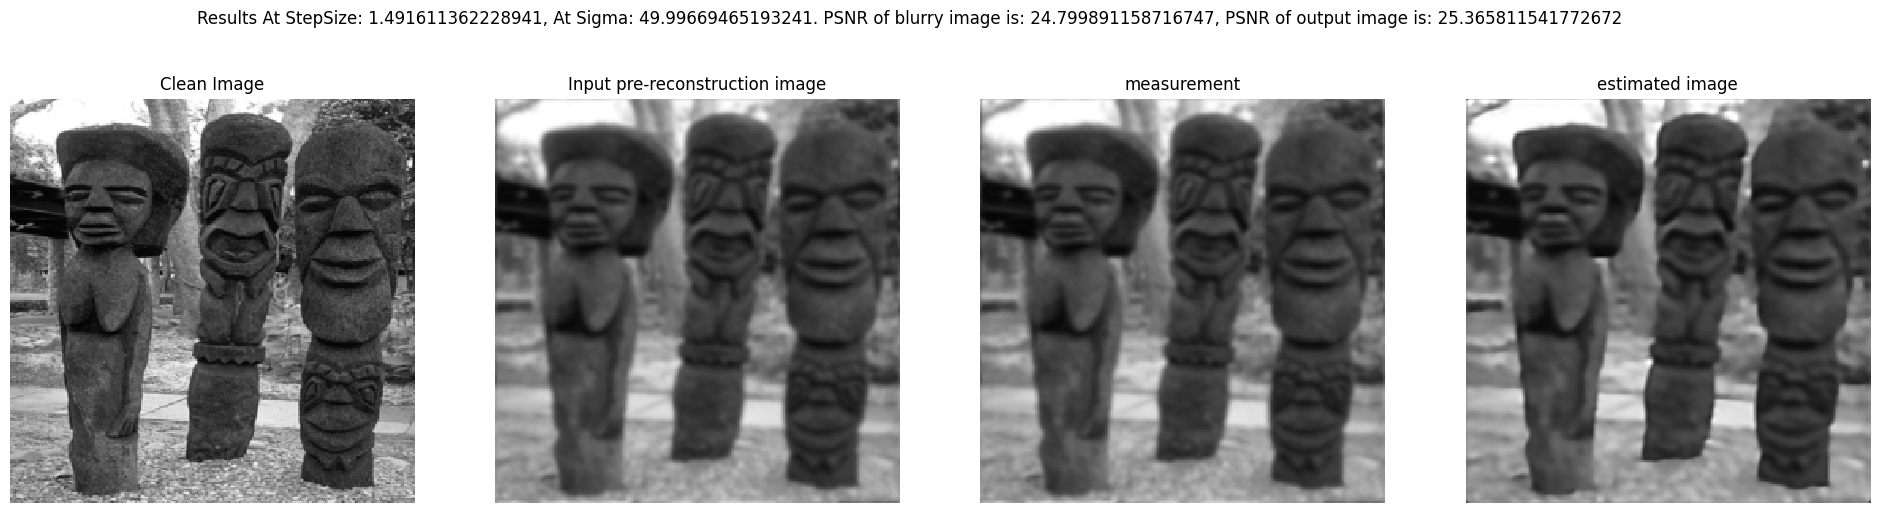

In [41]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {bestStepsize}, At Sigma: {sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')